# Import modules

In [1]:
import numpy as np
import pandas as pd
import liquidmodel as lm
import lleact as la
import matplotlib.pyplot as plt
%matplotlib inline

# Set epsilon12 and Nc 

In [2]:
"""
Parameters
----------
dim : int
    The dimension of the system
Nc : int
    coordination number of the lattice
epsilon12dk : float (unit: Kelvin)
    potential energy of interaction between component 1 and 2, divided by boltzmann constant
epsilon21dk : float (unit: Kelvin)
    potential energy of interaction between component 2 and 1, divided by boltzmann constant
epsilon11dk : float (unit: Kelvin)
    potential energy of interaction between component 1 and 1, divided by boltzmann constant
epsilon22dk : float (unit: Kelvin)
    potential energy of interaction between component 2 and 2, divided by boltzmann constant
"""
dim = 3
Nc = int( 2 * dim )
epsilon12dk = 1.
epsilon21dk = epsilon12dk
epsilon11dk = - epsilon12dk
epsilon22dk = - epsilon12dk

# Set RG parameters

In [3]:
"""
Parameters
----------
nx : int
    total number of mole fraction data (nx equally spaced points of x1 from 0 to 1)
L0 : 1D numpy array, float
    GRGT parameter
delta : 1D numpy array, float
    GRGT parameter
nl : int
    total number of L0 need to be calculated
nd : int 
    total number of delta need to be calculated
    
"""
nx = 1001
L0 = np.array([2.935])
delta = np.array([1.])
nl = len(L0)
nd = len(delta)

# Set parameter to objects

In [4]:
"""
Parameters
----------
liquidmodelname : list, string
    name of liquid model set in "la.Calc_binary_rg"
liquidmodelnamep : list, string
    name of liquid model 
nm : int
    total number of liquid model need to be calculated
calc_rg_object : list, instance of class "la.Calc_binary_rg"
    instance of class "la.Calc_binary_rg"
    
"""
liquidmodelname = ['NRTL']
liquidmodelnamep = ['Margules']
nm = len(liquidmodelname)
calc_rg_object = [None for im in range(nm)]

In [5]:
"""
Parameters
----------
a, b, c, d, e, f : 2X2 numpy array, float
    binary interation paramters of liquid model
Tc : 1D numpy array, float
    critical temperature for each model, that can be solved analytically in this system
    
"""
Tc = np.zeros(nm, dtype=float)
for im in range(nm):
    # Set the input variable for instance
    calc_rg_object[im] = la.Calc_binary_rg(liquidmodelname=liquidmodelname[im], iterationdata=False, nx=nx)

    # Set binary interation paramters
    a = d = e = np.zeros((2, 2), dtype=float)
    b12 = epsilon12dk - epsilon11dk
    b21 = epsilon21dk - epsilon22dk
    b = np.array([[0, b12], [b21, 0]]) * Nc / 2
    if liquidmodelnamep[im] == 'Margules': # Margules model
        c = f = np.zeros((2, 2), dtype=float)
        Tci = np.sum(b) / 2
        Tc[im] = Tci
    calc_rg_object[im].set_bip(a, b, c, d, e, f)
    
    # Set dimension of the system
    calc_rg_object[im].d = dim
    

# Set temperature array for each model

In [6]:
"""
Parameters
----------
T : 1D numpy array, float
    temperature points need to be calculated
pt : int
    total number of temperature points need to be calculated
"""
pt = 25
# T = np.linspace(3., 12., pt) # low T
T = np.linspace(12., 21., pt) # high T


# Free energy calculations

In [7]:
dgmix = np.zeros((nm, nl, nd, pt, nx), dtype=float)
dgmix_rg = np.zeros((nm, nl, nd, pt, nx), dtype=float)
for im, liquidmodelnamei in enumerate(liquidmodelnamep):
    print(f' * Liquid model : {liquidmodelnamei}+RG')
    for il, L0i in enumerate(L0):
        for idt, deltai in enumerate(delta):
            print(f'   * L0 = {L0i}, delta = {deltai}')
            calc_rg_object[im].set_rgp(lhat0=L0i, delta=deltai)
            calc_rg_object[im].set_rgp(iteration=calc_rg_object[im].nmax)
            for it, Te in enumerate(T):
                calc_rg_object[im].set_t(Te)
                calc_rg_object[im].calc_dgmix_rg()
                dgmix[im,il,idt,it,:] = calc_rg_object[im].dgmix_cg
                dgmix_rg[im,il,idt,it,:] = calc_rg_object[im].dgmix_rg
                print(f'     i = {it}, T = {Te} (K), iterations = {calc_rg_object[im].iteration}')

 * Liquid model : Margules+RG
   * L0 = 2.935, delta = 1.0
     i = 0, T = 12.0 (K), iterations = 8
     i = 1, T = 12.375 (K), iterations = 8
     i = 2, T = 12.75 (K), iterations = 8
     i = 3, T = 13.125 (K), iterations = 8
     i = 4, T = 13.5 (K), iterations = 8
     i = 5, T = 13.875 (K), iterations = 8
     i = 6, T = 14.25 (K), iterations = 8
     i = 7, T = 14.625 (K), iterations = 8
     i = 8, T = 15.0 (K), iterations = 8
     i = 9, T = 15.375 (K), iterations = 8
     i = 10, T = 15.75 (K), iterations = 8
     i = 11, T = 16.125 (K), iterations = 8
     i = 12, T = 16.5 (K), iterations = 8
     i = 13, T = 16.875 (K), iterations = 8
     i = 14, T = 17.25 (K), iterations = 8
     i = 15, T = 17.625 (K), iterations = 8
     i = 16, T = 18.0 (K), iterations = 8
     i = 17, T = 18.375 (K), iterations = 8
     i = 18, T = 18.75 (K), iterations = 8
     i = 19, T = 19.125 (K), iterations = 8
     i = 20, T = 19.5 (K), iterations = 8
     i = 21, T = 19.875 (K), iterations = 8


# Save the calculated data

In [8]:
pd.set_option("display.precision", 12)
strl = [f'dGmix_n/NRT (x1={xi[0]:.3f})' for xi in calc_rg_object[0].x.T]
column = ['Tr', 'n'] + strl
trl = np.array([])
n_rg = np.array([])
dgmixl = np.empty((0,nx))

for im, liquidmodelnamei in enumerate(liquidmodelnamep):
    for il, L0i in enumerate(L0):
        for idt, deltai in enumerate(delta):
            for it, Ti in enumerate(T):
                trl = np.append(trl, [Ti/Tc[im], Ti/Tc[im]]) # T / Tc(NRTL) instead of T / Tc(NRTL+RG)
                n_rg = np.append(n_rg, ['0', 'Converged'])
                dgmixl = np.append(dgmixl, dgmix[im,il,idt,it,:].reshape(1,nx), axis=0)
                dgmixl = np.append(dgmixl, dgmix_rg[im,il,idt,it,:].reshape(1,nx), axis=0)
            df1 = pd.DataFrame(zip(trl, n_rg), columns=['Tr', 'n'])
            df2 = pd.DataFrame(dgmixl, columns=strl)
            df1 = pd.concat([df1, df2], axis=1).reindex(df1.index)
            # df1.to_csv(f'Data\\dgmix data for {liquidmodelnamei}_GRGT_{il}_{idt}_beta_highT.csv')

# Plot $\frac{\Delta G_{mix}}{RT}$ vs. $x_1$ diagram

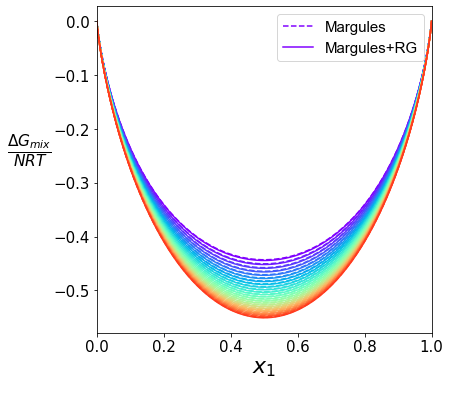

In [13]:
figure, ax = plt.subplots(1, 1)
figure.set_figheight(6)
figure.set_figwidth(6)
font1 = {'family' : 'Arial',
'weight' : 'normal',
'size'   : 15,
}
font2 = {'family' : 'Arial',
'weight' : 'normal',
'size'   : 22,
}

linewidthi = 1.5
filter_T = T.copy() #np.array([12])
filter_im = np.array([0])
il = 0
idt = 0
nft = len(filter_T)
nfm = len(filter_im)
color = plt.cm.rainbow(np.linspace(0, 1, nm+pt+1))
for im, liquidmodelnamei in enumerate(liquidmodelnamep):
    if im in filter_im:
        for it, Te in enumerate(T):
            if Te in filter_T:
                label = liquidmodelnamei if Te == filter_T[0] else None
                label_rg = f'{liquidmodelnamei}+RG' if Te == filter_T[0] else None
                ax.plot(calc_rg_object[im].x[0,:], dgmix[im,il,idt,it,:], '--', c=color[im+it], linewidth=linewidthi, label=label)
                ax.plot(calc_rg_object[im].x[0,:], dgmix_rg[im,il,idt,it,:], c=color[im+it], linewidth=linewidthi, label=label_rg)
                

ax.tick_params(labelsize=15)

xlabelstr1 = r'$x_{1}$'
ylabelstr1 = r'$\frac{\Delta G_{mix}}{NRT}$       '
ax.set_xlabel(xlabelstr1 + '\n', font2, rotation=0)
ax.set_ylabel(ylabelstr1, font2, rotation=0)
ax.set_xlim(0, 1)
# ax.set_ylim(-0.1, 0)
ax.legend(loc='best', prop=font1);